In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model


from env_test import GridEnvironment
from DQL_agent import DQNAgent
from DQL_agent_noreplay import DQNAgent_nr

In [2]:
# Load data
N = 10 # 10 EVs

# Get demand data
# TODO get apparent power from real and reactive, use just real for now
with open('Building Load Data/real_power_data.json', 'r') as json_file:
    real_dict = json.load(json_file)
    for key in real_dict.keys(): # get data from first key only (CAPTL_WF)
        demand_data = np.array(real_dict[key])
        break

# Get solar data
with open('PV Generation Data/pv_data.json', 'r') as json_file:
    pv_dict = json.load(json_file)
    for key in pv_dict.keys(): # get data from first key only (CAPTL_WF)
        solar_data = np.array(pv_dict[key])
        break

# Get wind data
with open('Wind Data/wind_data.json', 'r') as json_file:
    wind_dict = json.load(json_file)
    for key in wind_dict.keys(): # get data from first key only (CAPTL_WF)
        wind_data = np.array(wind_dict[key])
        break

In [3]:
#Quick fix for scaling Data
demand_data=demand_data/300
wind_data=wind_data*10

In [4]:
# Initialize environment with your chosen day's data

day_index=19 #random
timestep_length=.25 #in hours
batch_size = 10 #TWEAk
env = GridEnvironment(N, demand_data, solar_data, wind_data, day_index, timestep_length)

# Initialize DQN agent
agent = DQNAgent(state_size=env.state_size, action_size=env.action_size)

# Run for one episode (one day)
state = env.get_state()  # Reset environment to start state
total_reward = 0

T=96 #(15 minute steps in 24 hrs)

demand_profile = np.zeros(T)
solar_profile = np.zeros(T)
wind_profile = np.zeros(T)
PEV_profile = np.zeros(T)

for timestep in range(1, T+1):  # Assume T timesteps in a day
    current_demand, current_solar, current_wind = env.get_state()
    current_P_EV=env.P_EV

    current_state=np.concatenate([np.array([current_demand, current_solar, current_wind]), np.array(current_P_EV)])
    action = agent.act(state)  # Decide action based on current state

    reward, done, next_demand, next_solar, next_wind, next_P_EV = env.step(action)

    demand_profile[timestep - 1] = next_demand
    solar_profile[timestep - 1] = next_solar
    wind_profile[timestep - 1] = next_wind
    PEV_profile[timestep - 1] = np.sum(next_P_EV)

    # Construct the new state from the separated components
    next_state = np.concatenate([np.array([next_demand, next_solar, next_wind]), np.array(next_P_EV)])
    
    agent.remember(current_state, action, reward, next_state, done)  # Store experience

    #Replay not working?\
    if len(agent.memory) >= batch_size:
       agent.replay(batch_size) # Train the agent with a minibatch from memory

    state = next_state  # Move to the next state
    total_reward += reward

    if done:
        break

print("Total reward for the episode (day):", total_reward)


2024-04-12 16:50:05.936683: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Total reward for the episode (day): -913.41214673574


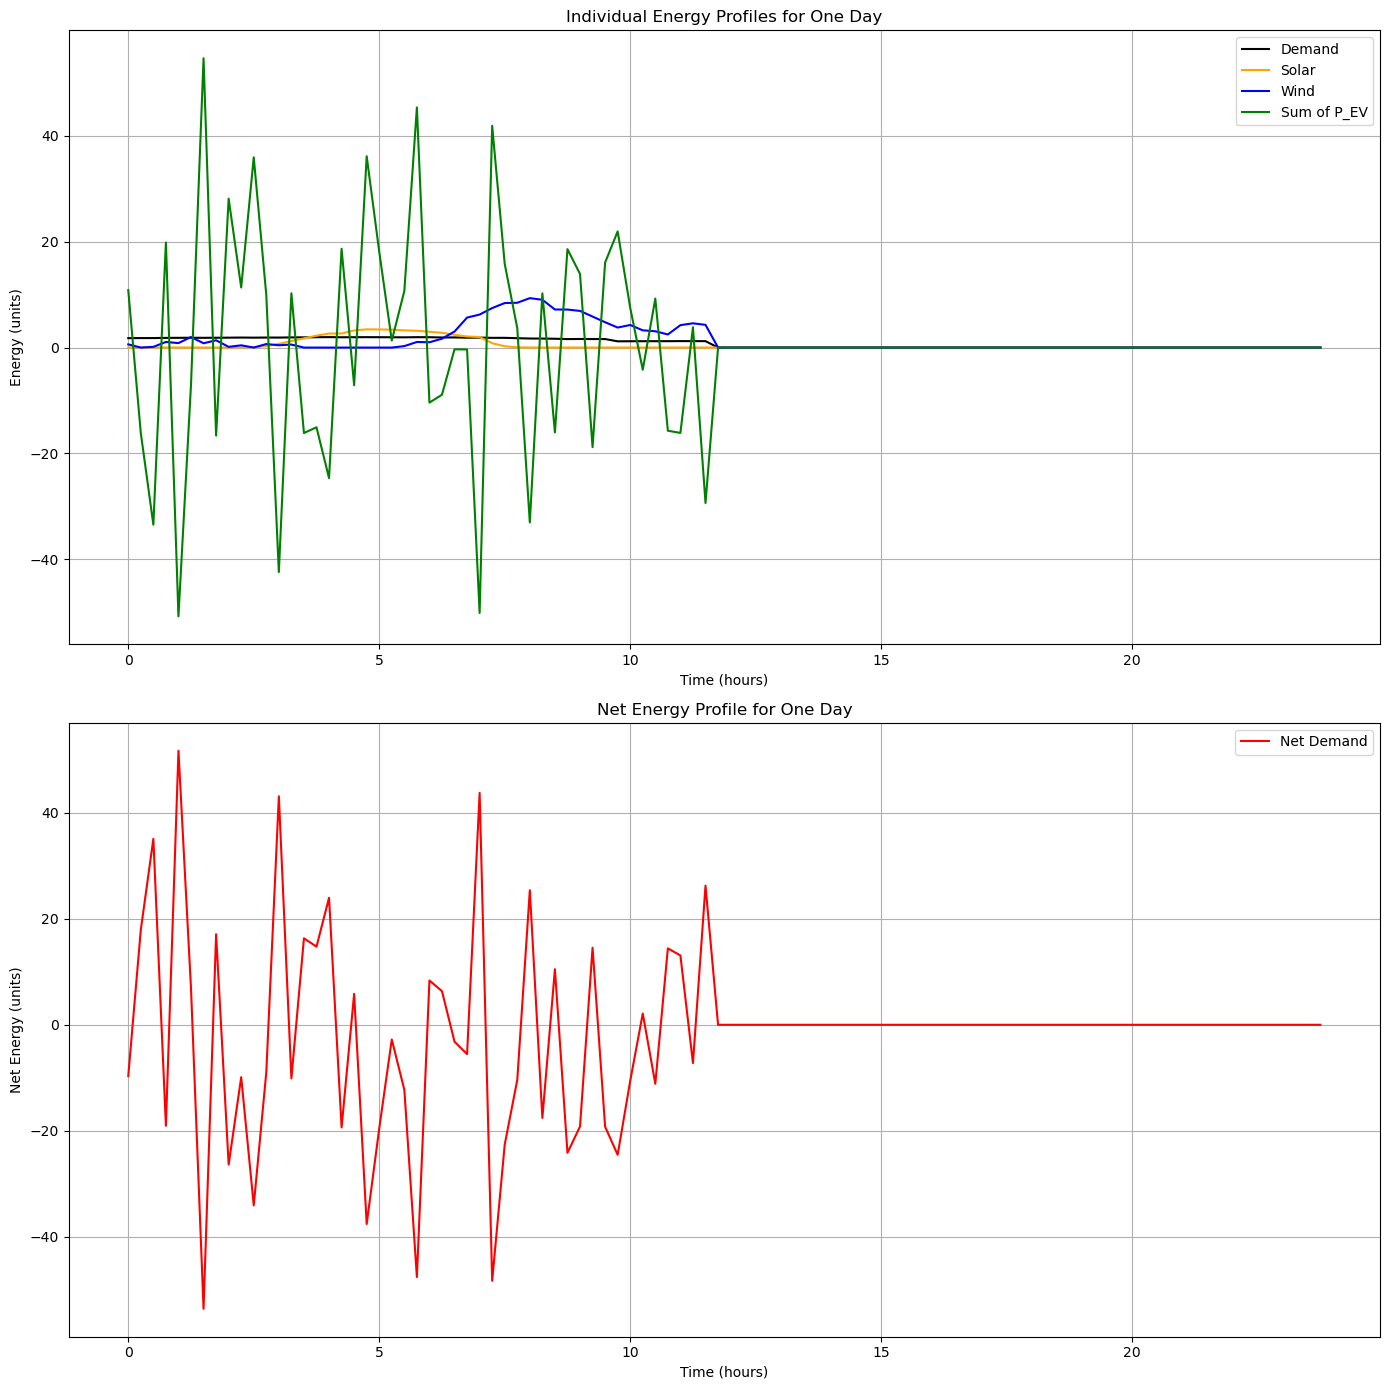

In [5]:
#Plot Episode

time_steps = np.arange(0, T * timestep_length, timestep_length)  # Generate a time axis

plt.figure(figsize=(14, 14))  # Increase the figure size to accommodate two subplots

# First subplot for individual profiles
plt.subplot(2, 1, 1)  # (rows, columns, panel number)
plt.plot(time_steps, demand_profile, label='Demand', color='black')
plt.plot(time_steps, solar_profile, label='Solar', color='orange')
plt.plot(time_steps, wind_profile, label='Wind', color='blue')
plt.plot(time_steps, PEV_profile, label='Sum of P_EV', color='green')
plt.xlabel('Time (hours)')
plt.ylabel('Energy (units)')
plt.title('Individual Energy Profiles for One Day')
plt.legend()
plt.grid(True)

# Second subplot for net demand
plt.subplot(2, 1, 2)  # (rows, columns, panel number)
net_demand_profile = demand_profile - solar_profile - wind_profile-PEV_profile
plt.plot(time_steps, net_demand_profile, label='Net Demand', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Net Energy (units)')
plt.title('Net Energy Profile for One Day')
plt.legend()
plt.grid(True)

# Show both plots
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()

In [6]:
#Attempt to loop through multiple episodes


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 1 finished with total reward -738.1344437652187
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 2 finished with total reward -853.8047294492892
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 3 finished with total reward -841.2850499795748
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 4 finished with total reward -728.380789932912
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 5 finished with total reward -809.7110269461494
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 6 finished with total reward -785.2206690053454
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 7 finished with total reward -1001.7946045485485
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 8 finished with total reward -946.1023027239975
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 9 finished with total reward -830.7809496784406
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 10 finished with total reward -740.9840548565606
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 11 finished with total reward -903.4734189829778
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 12

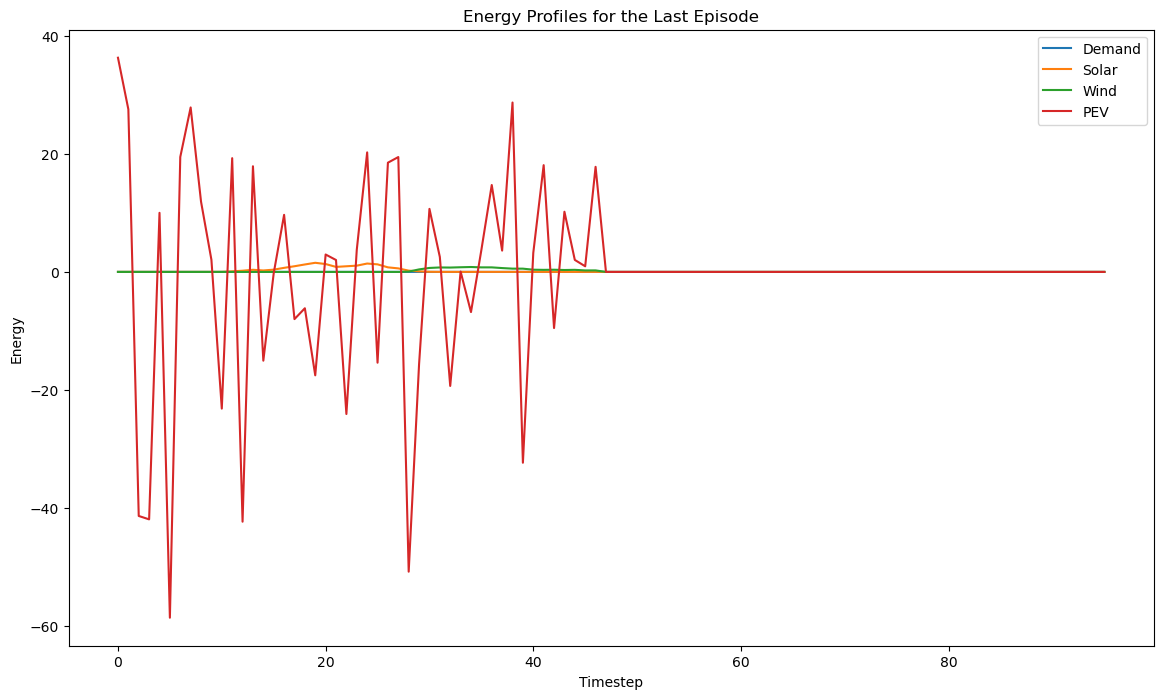

In [7]:
plt.figure(figsize=(14, 8))
plt.plot(demand_profile, label='Demand')
plt.plot(solar_profile, label='Solar')
plt.plot(wind_profile, label='Wind')
plt.plot(PEV_profile, label='PEV')
plt.legend()
plt.title('Energy Profiles for the Last Episode')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.show()